In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from typing import Union
import numpy as np
import pandas as pd
import joblib

import os
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pathlib
DATA_DIR = pathlib.Path.cwd()/'data/input'
OUT_DIR = pathlib.Path.cwd()/'data/output'

import sys 
sys.path.append(str(pathlib.Path.cwd()/'utils'))
from utils.misc_utils import load_train_test
from utils.clustering_utils import train_and_dump_clusters


from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


In [3]:
train, test = load_train_test()
pivot_volatilty = train.drop('id', axis=1).pivot_table(index='time_id', columns = 'stock_id', values = 'target').fillna(method='bfill').T
pivot_volatilty_corr = pivot_volatilty.T.corr()

random_seed = 123

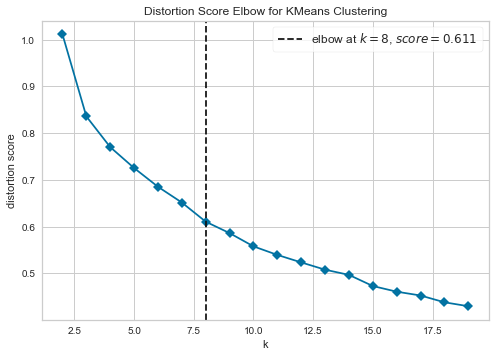

In [4]:
model = KMeans(random_state=random_seed)
elbow = KElbowVisualizer(
    model, 
    k=(2,20),
    metric='distortion',
    timings=False
    )

elbow.fit(pivot_volatilty)   
elbow.show() 

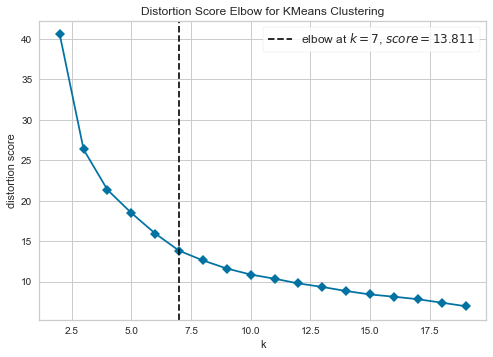

In [5]:
model = KMeans(random_state=random_seed)
elbow = KElbowVisualizer(
    model, 
    k=(2,20),
    metric='distortion',
    timings=False
    )

elbow.fit(pivot_volatilty_corr)   
elbow.show() 

model = KMeans()
elbow = KElbowVisualizer(
    model, k=(2,20), metric='distortion', timings=False
    )

elbow.fit(pivot_volatilty_corr)   
elbow.show() 

In [6]:
optimal_n_clusters = elbow.elbow_value_
optimal_k_means = KMeans(n_clusters=optimal_n_clusters)
optimal_k_means.fit_transform(pivot_volatilty_corr)
stock_clusters = optimal_k_means.predict(pivot_volatilty_corr)

In [7]:
import joblib 

def generate_return_corr():
    train, test = load_train_test()
    pivot_volatilty = (
        train
        .drop('id', axis=1)
        .pivot_table(index='time_id', columns = 'stock_id', values = 'target')
        .fillna(method='bfill')
        )
    
    pivot_volatilty_corr = pivot_volatilty.corr()
    return pivot_volatilty_corr

def best_cluster_kmeans(
    cluster_df: pd.DataFrame, 
    k: tuple = (2, 15),
    random_state: int = 123,
    **kwargs
    ):
    model = KMeans(random_state = random_state)
    elbow = KElbowVisualizer(
        model, 
        k=k, 
        **kwargs
        )

    elbow.fit(cluster_df)   
    optimal_n_clusters = elbow.elbow_value_
    optimal_k_means = KMeans(n_clusters=optimal_n_clusters, random_state = random_state)
    optimal_k_means.fit_transform(cluster_df)
    stock_clusters = optimal_k_means.predict(cluster_df)
    
    return stock_clusters, optimal_k_means


def train_and_dump_clusters(
    cluster_df: pd.DataFrame, 
    savepath: Union[pathlib.Path, str],
    clustering_name: str = 'cluster_result',
    id_col: str = None,
    **kwargs
    ):
    stock_clusters, _ = (
        best_cluster_kmeans(
        cluster_df = cluster_df, 
        **kwargs
        )
    )
    
    if id_col is None:
        cluster_result_dict = dict(zip(cluster_df.index, stock_clusters))
    else:
        cluster_result_dict = dict(zip(cluster_df[id_col], stock_clusters))
    savepath = f'{str(savepath)}/clusters/{clustering_name}.pkl'
    joblib.dump(cluster_result_dict, savepath)
    return cluster_result_dict
    

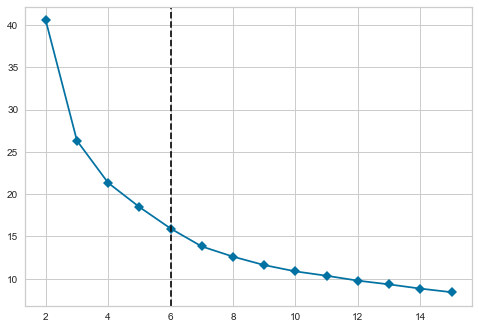

In [8]:
cluster_result = train_and_dump_clusters(
    cluster_df = pivot_volatilty_corr, 
    savepath=OUT_DIR,
    k = (2, 16),
    random_state=123,
    metric='distortion',
    timings=False
    )

# Dimensionality Reduction
for visualizing clusters

In [13]:
final_training_data = pd.read_pickle(OUT_DIR/'final_training_data.pkl')
final_test_data = pd.read_pickle(OUT_DIR/'final_test_data.pkl')

final_training_data['clusters'] = final_training_data.stock_id.map(cluster_result)
data_col = [col for col in final_training_data.columns if 'id' not in col]

In [10]:
#tsne = TSNE()
#tsne_transformed = tsne.fit_transform(final_training_data[data_col].fillna(0)).reshape((2, -1))

In [11]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(final_training_data[data_col].fillna(0)).reshape((2, -1))

In [16]:
id_by_clusters = final_training_data.reset_index().loc[:, ['clusters', 'stock_id']].drop_duplicates()
id_by_clusters.groupby('clusters')['stock_id'].apply(list)

clusters
0    [1, 101, 11, 124, 126, 37, 50, 55, 56, 62, 78,...
1    [10, 102, 109, 112, 113, 115, 116, 120, 122, 1...
2                                          [8, 80, 81]
3    [108, 110, 111, 21, 27, 31, 33, 38, 40, 58, 59...
4    [0, 100, 103, 104, 105, 107, 114, 118, 119, 12...
5                    [18, 3, 6, 61, 63, 75, 86, 9, 97]
Name: stock_id, dtype: object